## Image Classification with Convolutional Neural Networks

This is a demo of the implementation of an image classification system with convolutional neural networks in tensorflow. The basic goal is to execute a series of experiments for various parameters of the network. (e.g number of layers, learning rate, dropout rate, etc)

First, we import all the necessary packages.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import mlp.data_providers as data_providers
import time
from tensorflow.examples.tutorials.mnist import input_data as mnist_data
from collections import OrderedDict
from save_results import write_to_file, save_learning_curves
from fully_connected_layer import fclayer_regdropout
from convolutional_layer import cnn_stack, conv_layer
from learning_curves import plot_lc
%matplotlib inline

### Set training and validation set 

As a next step, we set training and the validation set for our experiments, using the CIFAR datasets data which is loaded by the providers functions. In order to do so, we need to set the path for the data providers by setting *"MLP_DATA_DIR=[your-path-to-]\data_folder"* in the command line before running a jupyter notebook. We select a batch size of 50 images.

In [2]:
batch = 50
train_data = data_providers.CIFAR10DataProvider('train', batch_size=batch)
valid_data = data_providers.CIFAR10DataProvider('valid', batch_size=batch)

### Keeping track of experiments results

Since we would like to store the results for multiple experiments we create a text file, where we will store the error and the accuracy scores at the end of the training epochs for both training and validation sets.

In [4]:
file_name ="number_of_convolutional_laters"
write_to_file(file_name,write ="Train error \t Valid error \t Train accuracy \t Valid Accuracy\n\n")
train_stats = OrderedDict()
valid_stats = OrderedDict()

### Define Network Parameters

At this stage, we define the network parameters, with which we are going to run our experiments. We use tf.placeholders variables for the inputs (images) and the targets (number of the image in one-hot enncoding). We also use them for dropout and L2 regularization un order to de-activate L2 and dropout, during testing.

In [5]:
inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
keep_dropout = tf.placeholder(tf.float32)
keep_l2 =tf.placeholder(tf.float32)
input_image = tf.reshape(inputs, [-1,32,32,3])

We can now define the hyperparameters for our network (including the selected learning rule and non-linear activation). In this experiment, we will use three layers (two hidden) in the fully connected network, so we define the dimensions for each of this case.

In [6]:
num_epochs = 30
learning_rate =0.001
dropout_rate = 0.9
l2_rate =0.01
output_hidden_1= 400     # Output dimension of first fc hidden layer
output_hidden_2= 200     # Output dimension of second fc hidden layer
conv_input_dimension= 16
nonlinearity = tf.nn.relu  # non linear activation function choice for layers output
learning_rule = tf.train.AdamOptimizer(learning_rate=learning_rate)

In this demo, we are interested in testing the performance of the classifier for different number of convolutional layers.

In [7]:
number_of_layers = [1,2,3,4]

### Executing Experiments in tensorflow

We are now ready to run the session. We use *tf.device('/gpu:0'):* to take advantage of the gpu recourses (if there is no NVIDIA GPU with CUDA availiable just switch it to cpu).


In [8]:
for conv_layers in number_of_layers:
    start_time = time.time() 
    with tf.device('/gpu:0'):
        
        # Convolutional Network
        cnn_network, input_dimension = cnn_stack(conv_layers, conv_input_dimension, input_image)
            
        # Fully Connected  Network
        with tf.name_scope('fc-layer-1'):
            hidden_1, L2_1= fclayer_regdropout(cnn_network,input_dimension, output_hidden_1, dropout_rate)     
        with tf.name_scope('fc-layer-2'):
            hidden_2, L2_2 = fclayer_regdropout(hidden_1, output_hidden_1, output_hidden_2, dropout_rate)   
        with tf.name_scope('output-layer'):
            outputs, L2_out = fclayer_regdropout(hidden_2, output_hidden_2, train_data.num_classes, 1, nonlinearity=tf.identity)
            
    with tf.name_scope('error'):
        l2_loss =l2_rate*(L2_1+L2_2+L2_out)
        softmax_loss = tf.nn.softmax_cross_entropy_with_logits(outputs, targets)
        error = tf.reduce_mean(softmax_loss+l2_loss)
        
    with tf.name_scope('accuracy'):
        accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)),tf.float32))
        
    with tf.name_scope('train'):
        train_step = learning_rule.minimize(error)

    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init)
        print("\n\n------ Number of Convolutional Layers = {} -------\n".format(conv_layers))
        write_to_file(file_name,write ="\nNumber of Convolutional Layers = {} \n".format(conv_layers))
        train_error=[]
        train_accuracy=[]
        valid_error=[]
        valid_accuracy=[]
        
        for e in range(num_epochs):
            s=time.time()
            
            # Training set
            epoch_error = 0.
            epoch_accuracy = 0.
            for input_batch, target_batch in train_data: 
                sess.run(train_step, feed_dict={inputs: input_batch, targets: target_batch, 
                keep_dropout:dropout_rate, keep_l2:l2_rate}) 
                batch_error, batch_acc = sess.run([error, accuracy], feed_dict={inputs: input_batch, targets: target_batch,keep_dropout:1,keep_l2:0})
                epoch_error += batch_error
                epoch_accuracy += batch_acc
            epoch_error /= train_data.num_batches
            epoch_accuracy /= train_data.num_batches
            train_error.append(epoch_error)
            train_accuracy.append(epoch_accuracy)
            print('End of epoch {0:02d}\nTraining Set: Error = {1:.3f} Accuracy = {2:.4f}'.format(e + 1, epoch_error, epoch_accuracy))
            
            # Validation Set
            epoch_error = 0.
            epoch_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run([error, accuracy],feed_dict={inputs: input_batch, targets: target_batch,keep_dropout:1,keep_l2:0})
                epoch_error += batch_error
                epoch_accuracy += batch_acc
            epoch_error /= valid_data.num_batches
            epoch_accuracy /= valid_data.num_batches
            valid_error.append(epoch_error)
            valid_accuracy.append(epoch_accuracy)
            print('Validation Set: Error = {0:.3f} Accuracy = {1:.4f}'.format(epoch_error, epoch_accuracy))                            
            #print('Epoch {0:02d}: Execution Time = {1:.4f} seconds \n'.format(e + 1, (time.time()-s)))
            
    train_stats[conv_layers]=[train_error,train_accuracy]
    valid_stats[conv_layers]=[valid_error,valid_accuracy]
    
    # writing to file in a convinient form
    write_to_file(file_name,write = str(conv_layers)+"  &  %.3f" % train_error[-1] + " & %.3f" % valid_error[-1] +" & %.2f" % train_accuracy[-1] +" &  %.2f \\ \n\n" % valid_accuracy[-1])
    print("\nTotal execution time = %.3f seconds " % (time.time() - start_time))



------ Number of Convolutional Layers = 1 -------

End of epoch 01
Training Set: Error = 2.483 Accuracy = 0.3832
Validation Set: Error = 1.906 Accuracy = 0.4098
End of epoch 02
Training Set: Error = 1.781 Accuracy = 0.4504
Validation Set: Error = 1.794 Accuracy = 0.4524
End of epoch 03
Training Set: Error = 1.727 Accuracy = 0.4729
Validation Set: Error = 1.734 Accuracy = 0.4621
End of epoch 04
Training Set: Error = 1.693 Accuracy = 0.4822
Validation Set: Error = 1.724 Accuracy = 0.4719
End of epoch 05
Training Set: Error = 1.664 Accuracy = 0.4956
Validation Set: Error = 1.709 Accuracy = 0.4693
End of epoch 06
Training Set: Error = 1.641 Accuracy = 0.5039
Validation Set: Error = 1.677 Accuracy = 0.4916
End of epoch 07
Training Set: Error = 1.623 Accuracy = 0.5150
Validation Set: Error = 1.718 Accuracy = 0.4762
End of epoch 08
Training Set: Error = 1.608 Accuracy = 0.5181
Validation Set: Error = 1.725 Accuracy = 0.4750
End of epoch 09
Training Set: Error = 1.601 Accuracy = 0.5173
Valid

### Visualization and saving

Finally, we present the error function and the accuracy over the training epochs for both training and validation set in 4 diferent scenarios. 

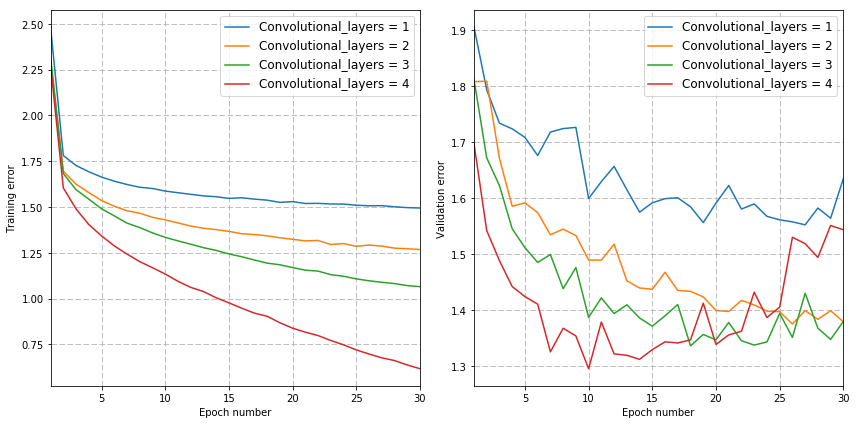

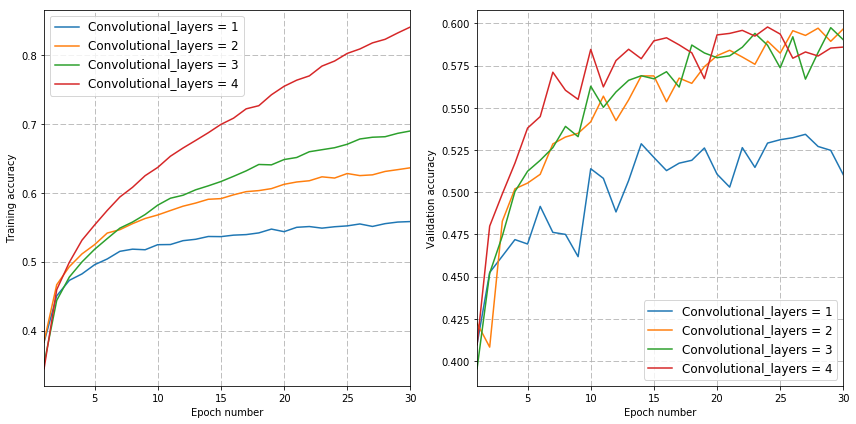

In [10]:
fig_1,fig_2=plot_lc(train_stats, valid_stats, num_epochs, label = "Convolutional_layers")
save_learning_curves(fig_1,fig_2,label="Convolutional_layers")